In [64]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from operator import itemgetter

class FileCollector:
    def collect(self, InputPath, Postfix):
        Files = []
        for root, dirs, files in os.walk(InputPath):
            for file in files:
                if file.endswith(Postfix):
                    Files.append(root + '/' + file)
        return Files

class BenchmarkDictListsGen:
    """
    Return format:
    BenchmarksInfo = {"name": {"set": [...] , "cpu-cycles": [number], "func":{"func_name":[usage]} }}
    """
    def genFullInfo(self, Files):
        BenchmarksInfo = {}
        # Read files into list
        AllLines = []
        for file in Files:
            with open(file, 'r') as stream:
                for line in stream:
                    lineList = line.split(';')
                    AllLines.append(lineList)
                stream.close()
        # dict with benchmark name as keys
        '''
        line example: "name"; set | series_number ; cpu-cycles | number; func | name | usage; ...
        The value in DictContainerList = ["func"] will use dict as its container instead of list
        '''
        DictContainerList = ["func"]
        for lineInfo in AllLines:
            # if the key not exist, create the entry
            benchmarkName = lineInfo[0].strip()
            if benchmarkName not in BenchmarksInfo:
                BenchmarksInfo[benchmarkName] = {}
            # extract info in line, and skip those cannot split with "|" as key.
            for singleInfo in lineInfo:
                splitSingleinfo = singleInfo.split('|')
                if len(splitSingleinfo) < 2:
                    continue
                #ex. subKey = "set", "cpu-cycles", "func"
                subKey = splitSingleinfo[0].strip()
                if subKey in  DictContainerList:
                    UseDictContainer = True
                else:
                    UseDictContainer = False
                if BenchmarksInfo[benchmarkName].get(subKey) is None:
                    if UseDictContainer:
                        BenchmarksInfo[benchmarkName][subKey] = {}
                    else:
                        BenchmarksInfo[benchmarkName][subKey] = []
                if UseDictContainer == False:
                    BenchmarksInfo[benchmarkName][subKey].append(splitSingleinfo[1].strip())
                else:
                    # Currently, only extract func usage
                    SubSubKey = splitSingleinfo[1].strip()
                    if BenchmarksInfo[benchmarkName][subKey].get(SubSubKey) is None:
                        BenchmarksInfo[benchmarkName][subKey][SubSubKey] = []
                    BenchmarksInfo[benchmarkName][subKey][SubSubKey].append(splitSingleinfo[2].strip())
        return BenchmarksInfo
    """
    Return Format: As same as genFullInfo()
    Input:
    1. BenchmarksInfo = genFullInfo()'s return value
    2. SortedSigmaList = genCycleStdDeviation()'s second return value
    """
    def stripSignificantSigmaWithFullInfo(self, BenchmarksInfo, SortedSigmaList, Percentage, RecordLoc):
        totalCount = len(SortedSigmaList)
        rmCount = int(Percentage*totalCount)
        file = open(RecordLoc, 'w')
        for benchmark in SortedSigmaList[-rmCount:]:
            name = benchmark[0]
            BenchmarksInfo.pop(name)
            file.write("{}; cpu-cycles-sigma | {}\n".format(name, benchmark[1]))
        file.close()
        return BenchmarksInfo
    
    """
    Input: Use genFullInfo() to get the input
    Return Value: 
    1.  {"name":{"cpu-cycles-mean": num1, "cpu-cycles-sigma": num2}}
    2.  [["name", stddev]] sorted with stddev increasingly
    """
    def genCycleStdDeviation(self, FullInfo):
        retDict = {key: {} for key in list(FullInfo.keys())}
        retList = []
        for benchmarkName, BenchmarkDict in FullInfo.items():
            # Convert string to int
            intResults = list(map(int, BenchmarkDict["cpu-cycles"]))
            mean = statistics.mean(intResults)
            # Normalized with its average
            normResults = [cycle/mean for cycle in intResults]
            normSigma = statistics.stdev(normResults)
            retList.append([benchmarkName, normSigma])
            # Record original value in dict
            origSigma = statistics.stdev(intResults)
            retDict[benchmarkName]["cpu-cycles-mean"] = int(mean)
            retDict[benchmarkName]["cpu-cycles-sigma"] = int(origSigma)
        retList = sorted(retList, key = itemgetter(1))
        return retDict, retList
    
    """
    No Return Value.
    Input:
    1. First return value from genCycleStdDeviation()
    
    Record Format:
    "name"; Mean-cpu-cycles | number; Sigma-cpu-cycles | number 
    """
    def RecordMeasurableBenchmarks(self, MeanAndSigmaDict, OutputPath):
        file = open(OutputPath, "w")
        for Name, Dict in MeanAndSigmaDict.items():
            file.write("{}; cpu-cycles-mean | {}; cpu-cycles-sigma | {}\n".format(
                Name, Dict["cpu-cycles-mean"], Dict["cpu-cycles-sigma"]))
        file.close()
            


class GraphDrawer:
    OutputLoc = "./output/"
    """
    Input: InputDict from genCycleStdDeviation()
    """
    def DrawLineChartWithError(self, Title, InputDict, meanKey, sigmaKey):
        x = range(1, len(InputDict.keys())+1)
        y = []
        # twice sigma is about 95% of the data
        symmetricError= []
        '''
        Use InputDict to create a list of mean and sigma with meanKey.
        Sorted with mean decreasingly
        '''
        MeanWithSigma = []
        for key, value in InputDict.items():
            MeanWithSigma.append([value[meanKey], value[sigmaKey]])
        MeanWithSigma = sorted(MeanWithSigma, key = itemgetter(0), reverse=True)
        for Tuple in MeanWithSigma:
            y.append(Tuple[0])
            symmetricError.append(Tuple[1]*2)
        # Split into three line chart
        splitCount = 3
        step = len(x) // splitCount
        plt.rc('font', size=3.5)
        fig = plt.figure(dpi=300)
        fig.suptitle(Title, fontweight='bold', fontsize=11, y=1.03)
        mean_patch = mpatches.Patch(color='yellow', label='Mean of cpu-cycles with perf')
        sigma_patch = mpatches.Patch(color='black', label='Twice Sigma of cpu-cycles with perf')
        for i in range(splitCount):
            ax = fig.add_subplot(3,1,i+1)
            ax.set_ylabel('cpu-cycles, scale at left-top corner')
            ax.set_xlabel('benchmark number, sorted by mean cpu-cycles')
            indexStart = i*step
            indexEnd = (i+1)*step
            ax.errorbar(x[indexStart:indexEnd], y[indexStart:indexEnd], yerr=symmetricError[indexStart:indexEnd]
                        , fmt='-', ecolor='black', capsize=1.5,  linewidth=0.75, color='yellow')
            plt.legend(handles=[mean_patch, sigma_patch])
        plt.tight_layout()
        plt.show()
        fig.savefig(self.OutputLoc + Title + ".png", dpi=fig.dpi, bbox_inches='tight')
        
    # Helper method
    def GraphGenerator_AutoLabel(self, rects, ax, location):
        horizontalAlign = 'center'
        if location == "up":
            verticalAlign='bottom'
        else:
            verticalAlign='top'

        for rect in rects:
            h = rect.get_height()
            if location == "up":
                h = h * 1.0
            else:
                h = h * 1.05
            label = "%.2f" % (h)
            ax.text(rect.get_x()+rect.get_width()/2., h, label,
                    ha=horizontalAlign, va=verticalAlign)
    """
    Input:
    1. Title name
    2. and 3. are Second return value from genCycleStdDeviation()
    """
    def DrawSigmaComparsion(self, Title, SingleCoreSortedSigmaList, MultiCoreSortedSigmaList):
        '''
        Prepare the chart input
        '''
        x = []
        y1 = []
        y2 = []
        tmp = []
        for SingleCoreBnechmark in SingleCoreSortedSigmaList:
            x.append(SingleCoreBnechmark[0])
            y1.append(SingleCoreBnechmark[1])
        for MultiCoreBnechmark in MultiCoreSortedSigmaList:
            name = MultiCoreBnechmark[0]
            if name in x:
                y2.append(MultiCoreBnechmark[1])
        '''Draw'''
        plt.rc('font', size=2.5)
        fig = plt.figure(dpi=300)
        width = 0.27 # the width of the barspass
        
        # Split into two bar chart
        splitCount = 2
        step = len(x) // splitCount
        SingleCore_patch = mpatches.Patch(color='yellow', label='Normalized SingleCore Standard Deviation')
        MultiCore_patch = mpatches.Patch(color='green', label='Normalized MultiCore Standard Deviation')
        for i in range(splitCount):
            indexStart = i*step
            indexEnd = (i+1)*step
            x_sub = x[indexStart:indexEnd]
            y1_sub = y1[indexStart:indexEnd]
            y2_sub = y2[indexStart:indexEnd]
            ax = fig.add_subplot(2, 1 , i+1)
            index = np.arange(len(x_sub))
            rects1 = ax.bar(index, y1_sub, width, color='yellow')
            rects2 = ax.bar(index + width, y2_sub, width, color='green')
            self.GraphGenerator_AutoLabel(rects1, ax, "up")
            #self.GraphGenerator_AutoLabel(rects2, ax, "down")
            self.GraphGenerator_AutoLabel(rects2, ax, "up")
            ax.set_ylabel('Normalized Standard Deviation Single/Multi-Core Comparision With Standard Clang-5.0')
            ax.set_xticks(index + width)
            ax.set_xticklabels(x, rotation=90)
            plt.legend(handles=[SingleCore_patch, MultiCore_patch])
        
        fig.suptitle(Title, fontweight='bold', fontsize=10, y=1.01)
        plt.tight_layout()
        plt.show()
        fig.savefig(self.OutputLoc + Title + ".png", dpi=fig.dpi, bbox_inches='tight')


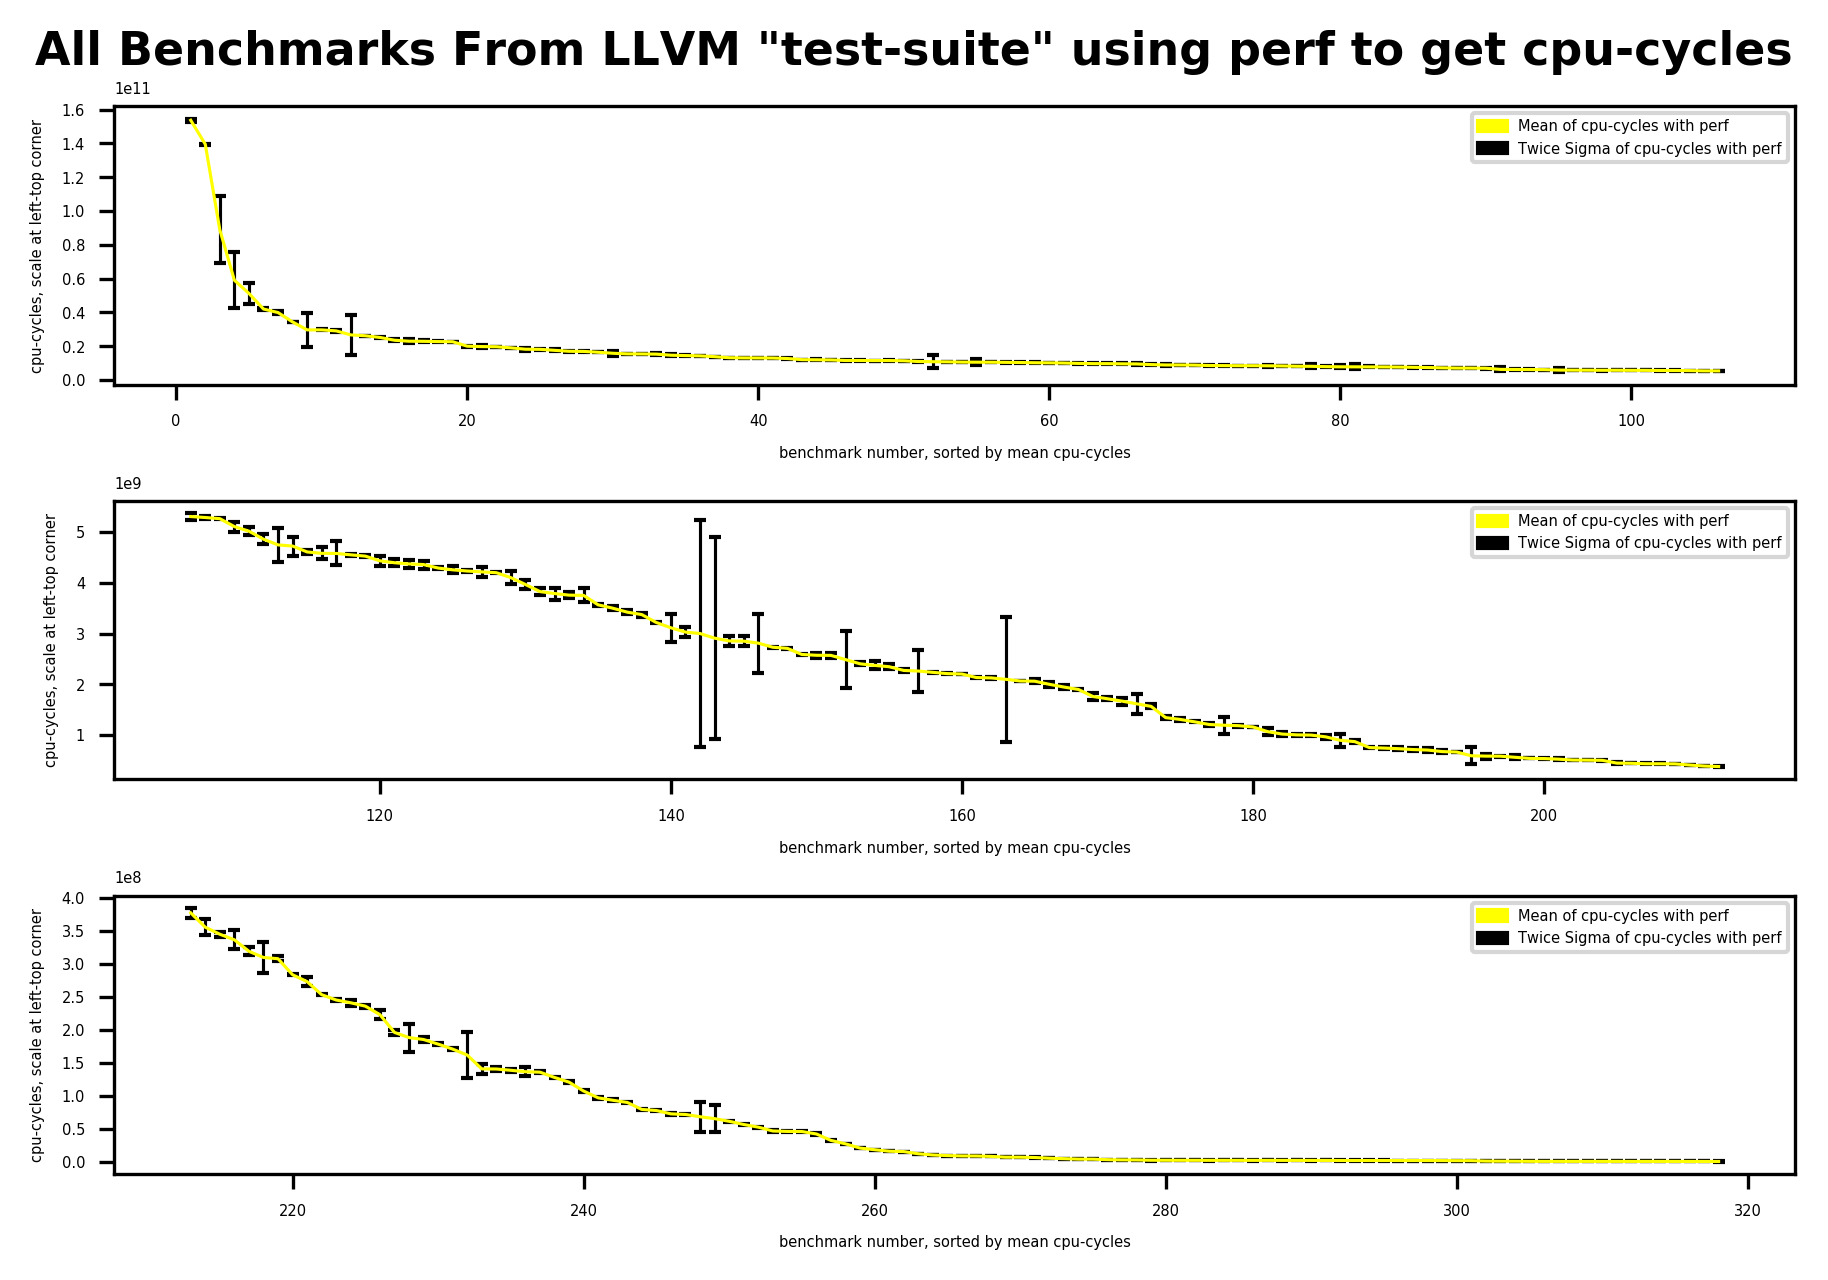

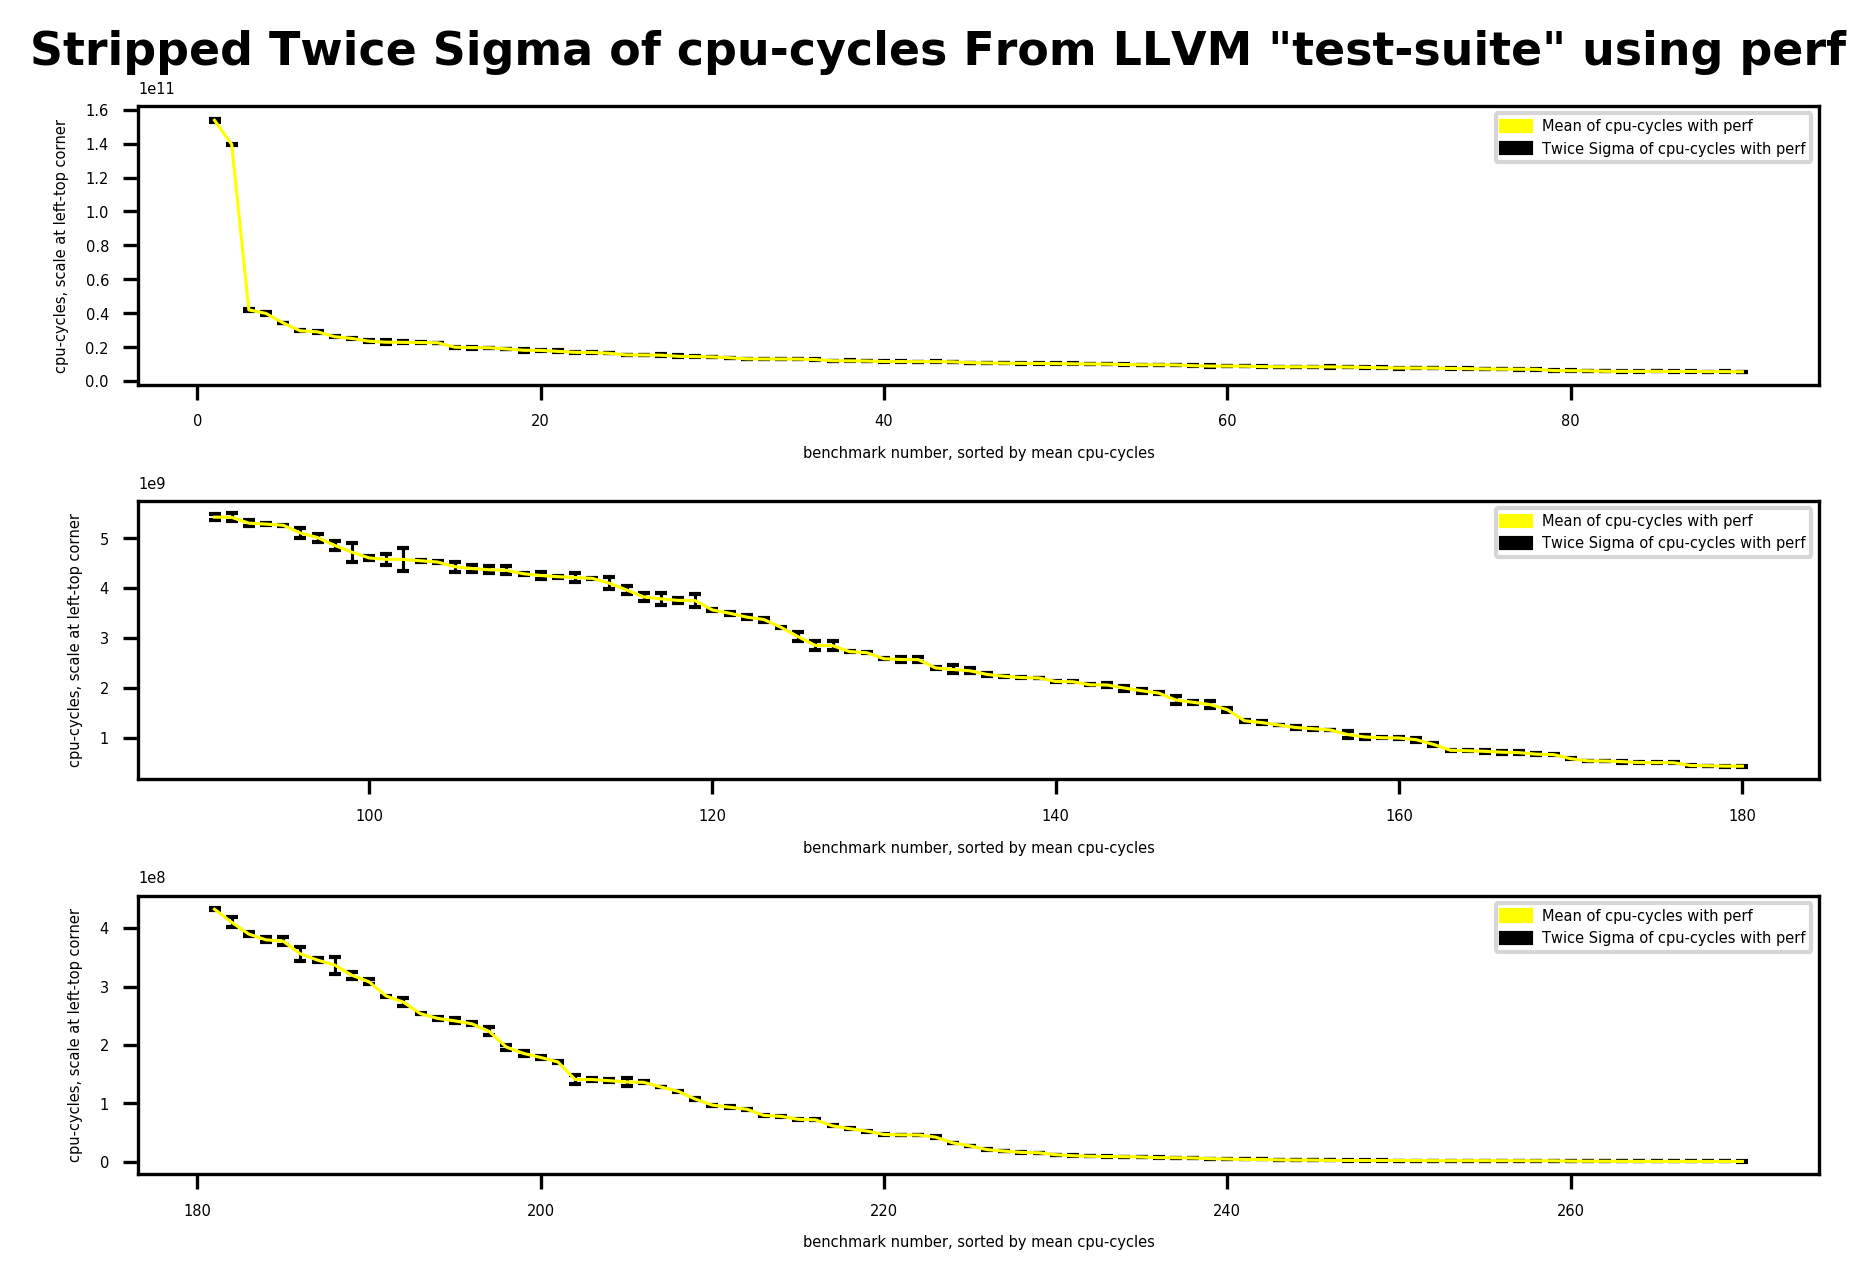

Done.


In [14]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from operator import itemgetter

if __name__ == '__main__':
    '''
    Gather all std files
    '''
    # Get input files
    Input = FileCollector()
    StdFiles = Input.collect("./input/STD", "_Features")
    '''
    Gather all information in files
    '''
    # Get full info about the benchmarks
    benchmarks = BenchmarkDictListsGen()
    stdBenchmarks = benchmarks.genFullInfo(StdFiles)
    '''
    Draw the mean and sigma graph based on full info
    '''
    # Use FullInfo to generate standard deviation
    MeanAndSigmaDict, SortedSigmaList= benchmarks.genCycleStdDeviation(stdBenchmarks)
    # Use arranged data to draw graph
    drawer = GraphDrawer()
    drawer.DrawLineChartWithError("All Benchmarks From LLVM \"test-suite\" using perf to get cpu-cycles", 
                                  MeanAndSigmaDict, "cpu-cycles-mean", "cpu-cycles-sigma")
    '''
    Strip the full info based on mean and sigma 
    '''
    # Remove the benchmarks that their sigma affects too much
    # In our case, the sigma threshold = 3%
    stripStdBenchmarks = benchmarks.stripSignificantSigmaWithFullInfo(stdBenchmarks, SortedSigmaList, 0.15, "./output/RemovedStdBenchmarkSigma")
    '''
    Draw the mean and sigma graph based on the new full info
    '''
    # Use FullInfo to generate standard deviation
    MeanAndSigmaDict, SortedSigmaList= benchmarks.genCycleStdDeviation(stripStdBenchmarks)
    # Use arranged data to draw graph
    drawer.DrawLineChartWithError("Stripped Twice Sigma of cpu-cycles From LLVM \"test-suite\" using perf", 
                                  MeanAndSigmaDict, "cpu-cycles-mean", "cpu-cycles-sigma")
    '''
    Record the real measurable benchmarks
    '''
    benchmarks.RecordMeasurableBenchmarks(MeanAndSigmaDict, "./output/MeasurableStdBenchmarkMeanAndSigma")
    
    
    print("Done.")

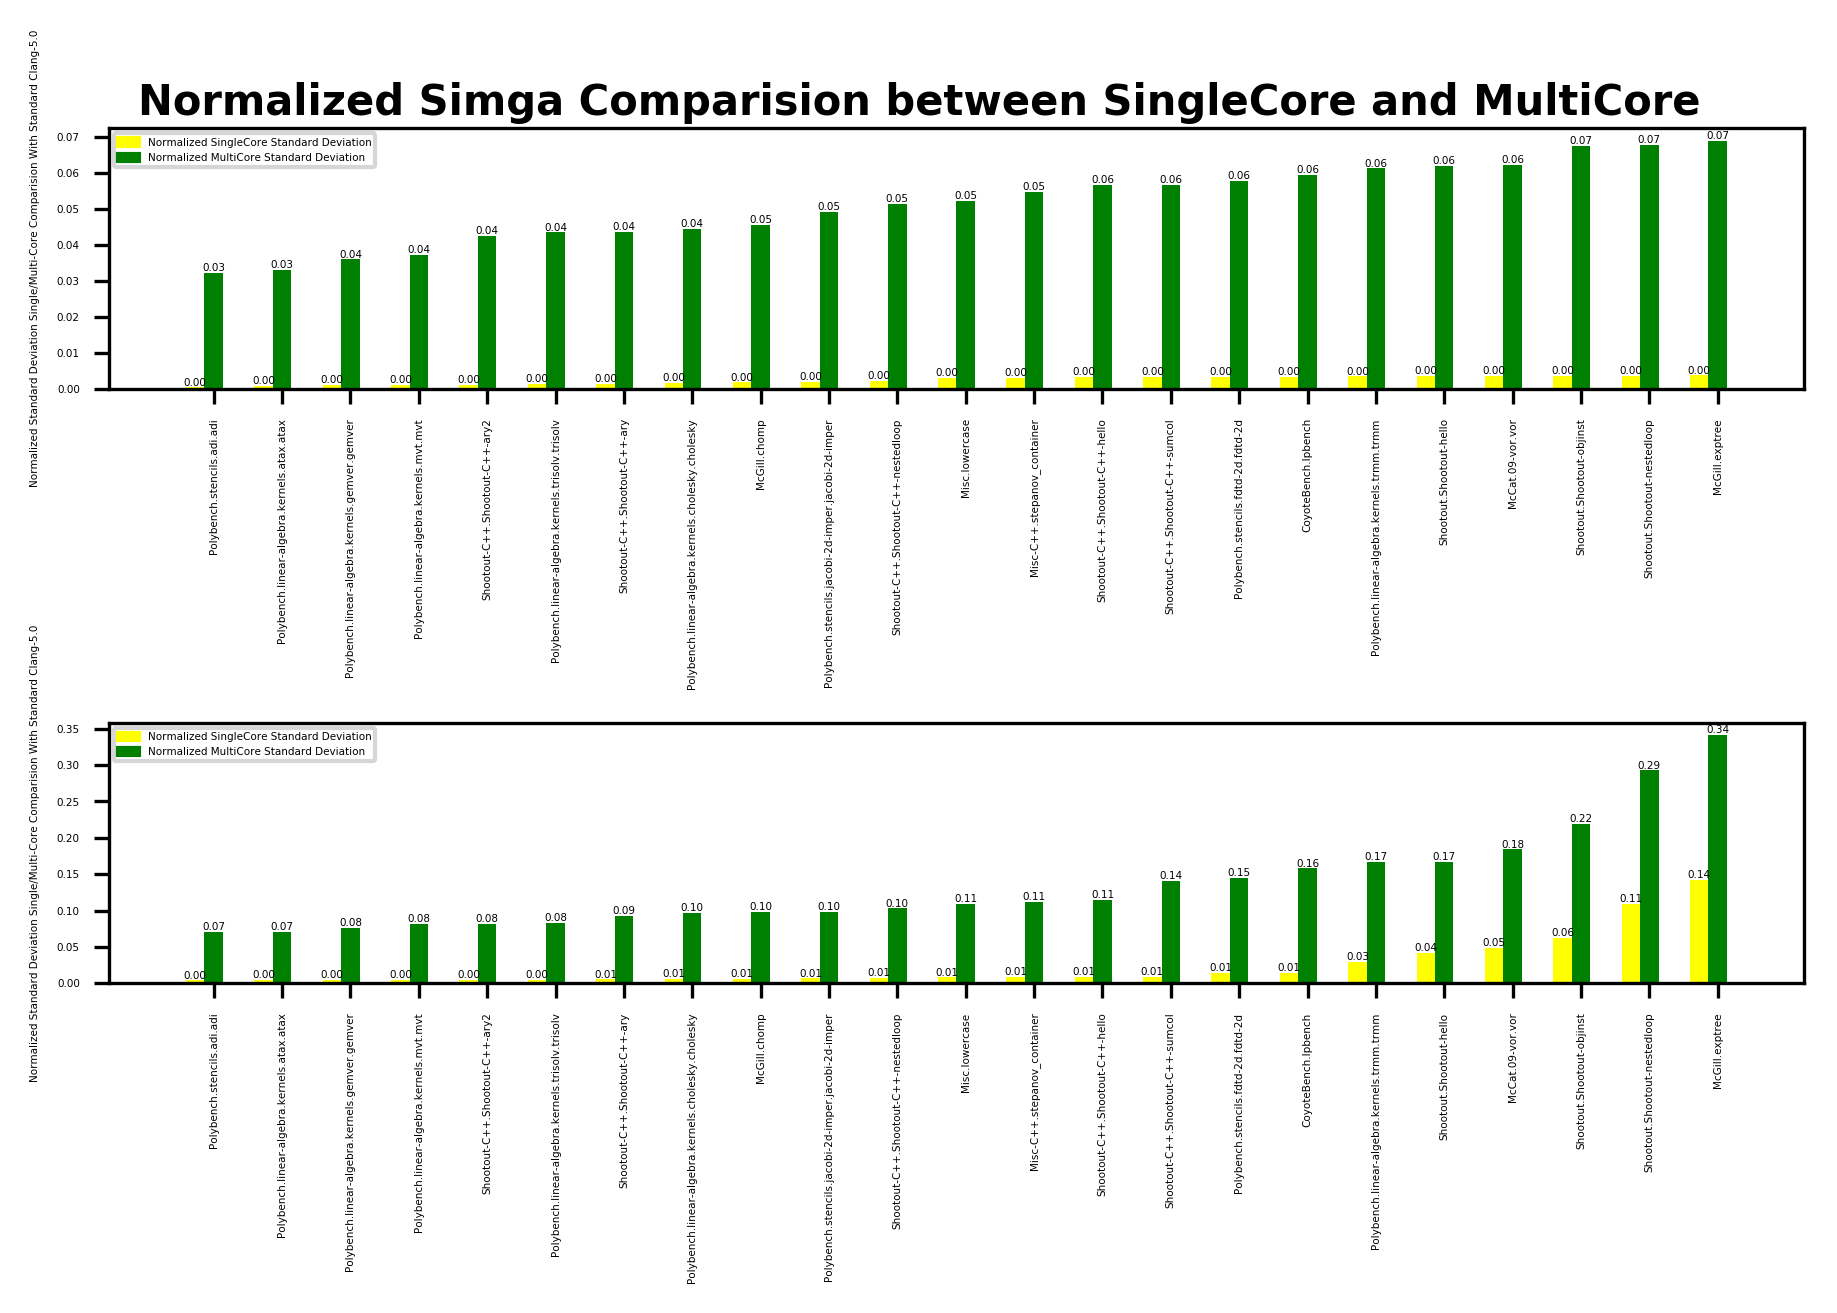

In [65]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from operator import itemgetter

if __name__ == '__main__':
    '''
    Gather all std files
    '''
    # Get input files
    Input = FileCollector()
    StdSimgaFiles = Input.collect("./input/SingleCoreSTD", "_Features")
    StdFiles = Input.collect("./input/STD", "_Features")
    '''
    Gather all information in files
    '''
    # Get full info about the benchmarks
    benchmarks = BenchmarkDictListsGen()
    stdSigmaBenchmarks = benchmarks.genFullInfo(StdSimgaFiles)
    stdBenchmarks = benchmarks.genFullInfo(StdFiles)
    '''
    Draw the sigma graph based on full info
    '''
    # Use FullInfo to generate standard deviation
    SingleCoreMeanAndSigmaDict, SingleCoreSortedSigmaList= benchmarks.genCycleStdDeviation(stdSigmaBenchmarks)
    MultiCoreMeanAndSigmaDict, MultiCoreSortedSigmaList= benchmarks.genCycleStdDeviation(stdBenchmarks)
    # Use arranged data to draw graph
    drawer = GraphDrawer()
    drawer.DrawSigmaComparsion("Normalized Simga Comparision between SingleCore and MultiCore", 
                                  SingleCoreSortedSigmaList, MultiCoreSortedSigmaList)
    
    